From: https://github.com/higgsfield/RL-Adventure/blob/master/3.dueling%20dqn.ipynb

In [1]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F


from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

## Cuda

In [2]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

## Replay Buffer

In [3]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
#         state      = np.expand_dims(state, 0)
#         next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
#         print(len(state), len(action), len(reward), len(next_state), state[0].shape)
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

## Network Architecture

Fully Connected

In [4]:
class DuelingDQN(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(DuelingDQN, self).__init__()
        
        
        self.feature = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU()
        )
        
        self.advantage = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_outputs)
        )
        
        self.value = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        x = self.feature(x)
        advantage = self.advantage(x)
        value     = self.value(x)
        return value + advantage  - advantage.mean()
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), requires_grad=False)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

Convolutional

In [5]:
class DuelingCnnDQN(nn.Module):
    def __init__(self, input_shape, num_outputs):
        super(DuelingCnnDQN, self).__init__()
        
        
        self.input_shape = input_shape
        self.num_actions = num_outputs
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.advantage = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, num_outputs)
        )
        
        self.value = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        advantage = self.advantage(x)
        value     = self.value(x)
        return value + advantage  - advantage.mean()
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def boltzmann_action(self, state, temperature):
        state   = Variable(torch.FloatTensor(np.float32(state)), requires_grad=False)
        q_value = self.forward(state)
        q_value = q_value.squeeze()
        q_value = q_value.detach().cpu().numpy()
        
        # softmax calculation
#         set_trace()
        exp_probabilities = np.exp(q_value / temperature)
        probabilities = exp_probabilities / np.sum(exp_probabilities)
        # make sure probs sum to 1
        probabilities[-1] = 1 - np.sum(probabilities[:-1])
        # choose actions according to the probabilities
        action = np.random.choice(range(env.action_space.n), p=probabilities)
        return action, probabilities
        
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)), requires_grad=False)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

## Functions

Target Network Update

In [6]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

Loss Calculation

In [7]:
def compute_td_loss(batch_size, replay_buffer_func, current_model, target_model):
    state, action, reward, next_state, done = replay_buffer_func.sample(batch_size)
    
#     print(state.shape)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = current_model(state)
    next_q_values = target_model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
#     print(q_value.shape)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - expected_q_value.detach()).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss, q_value, next_q_value

Plotting

In [8]:
def plot(frame_idx, rewards, losses, q_val, e_qval):
    clear_output(True)
    plt.figure(figsize=(20,10))
    plt.subplot(221)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(222)
    plt.title('loss')
    plt.plot(losses)
    plt.subplot(223)
    plt.title('Q-Value')
    plt.plot(q_val)
    plt.subplot(224)
    plt.title('Next Q-Value')
    plt.plot(e_qval)
    plt.show()

# Training

## Safelife

Environment

In [9]:
import gym 

class ImageToPyTorch_Safelife(gym.ObservationWrapper):
    """
    Image shape to num_channels x weight x height
    """
    def __init__(self, env):
        super(ImageToPyTorch_Safelife, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.uint8)

    def observation(self, observation):
        return np.swapaxes(observation, 3, 1)
    

def wrap_pytorch_safelife(env):
    return ImageToPyTorch_Safelife(env)

In [10]:
from safelife_factory import environment_factory
import datetime
# from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch
env = environment_factory(safelife_levels =['random/prune-still'],logdir='./safelife-data/prune-still-copy-2-'+ datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
env = wrap_pytorch_safelife(env)

Exploration Policy - Epsilon Greedy

In [11]:
epsilon_start = 1.0
epsilon_final = 0.05
epsilon_decay = 50000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

Neural Network Definition

In [12]:
current_model = DuelingCnnDQN(env.observation_space.shape, env.action_space.n)
target_model  = DuelingCnnDQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), lr=0.0003)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

update_target(current_model, target_model)

Training Loop

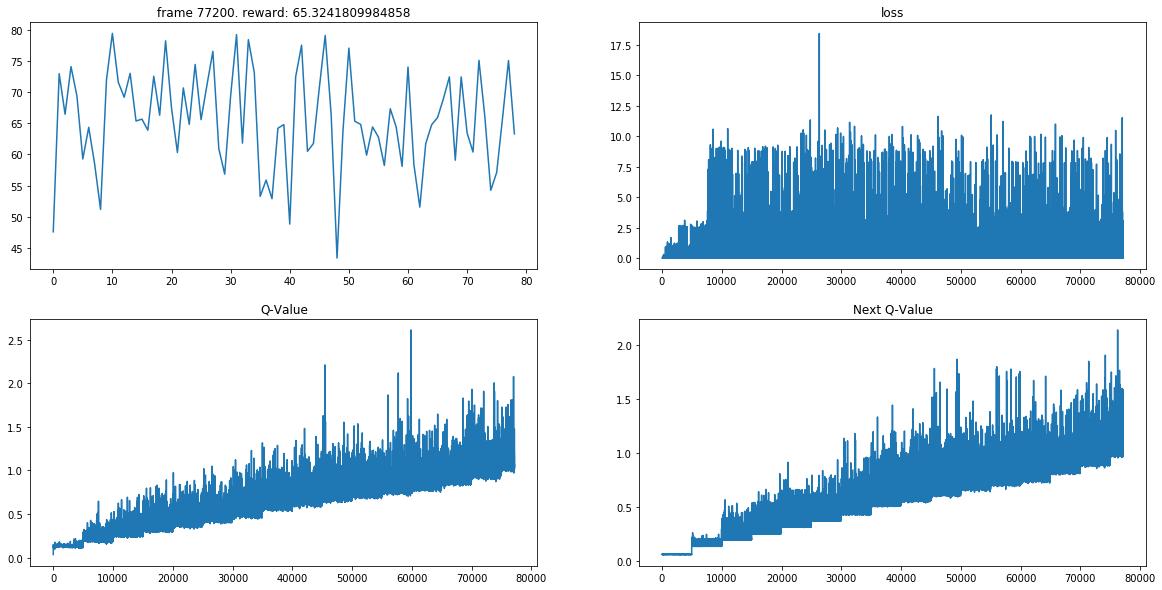

Epsilon:  0.25284902529635284


In [ ]:
num_frames = int(10e7)
batch_size = 32
gamma      = 0.97

losses = []
q_mean = []
e_q_mean = []
all_rewards = []
episode_reward = 0
current_temp = 0.8

state = env.reset()

for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
#     state = torch.Tensor(state.astype(int)).permute(0,3,2,1).numpy()
#     action = current_model.act(state, epsilon)
    action, prop = current_model.boltzmann_action(state, current_temp)
    
    if type(action) != int:
        action = action.item()
        
        
    
    next_state, reward, done, _ = env.step(action)
#     state = torch.Tensor(state.astype(int)).permute(0,3,2,1).numpy()
#     next_state = torch.Tensor(next_state.astype(int)).permute(0,3,2,1).numpy()
#     print('loop1', state.shape)
#     print('loop2', next_state.shape)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss, q_val, expected_q_val = compute_td_loss(batch_size, replay_buffer, current_model, target_model)
        losses.append(loss.item())
        q_mean.append(q_val.data.mean().item())
        e_q_mean.append(expected_q_val.data.mean().item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses, q_mean, e_q_mean)
        print('Epsilon: ', epsilon_by_frame(frame_idx))
        
    if frame_idx % 5000 == 0:
        update_target(current_model, target_model)